# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [8]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [3]:
ls /data/lfw/Kelli_White/

Kelli_White_0001.jpg  Kelli_White_0002.jpg


In [4]:
human_files[:3]

array(['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg',
       '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg',
       '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg'],
      dtype='<U90')

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


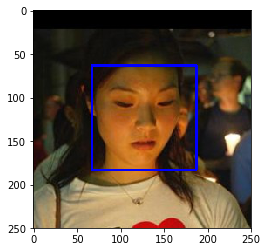

In [10]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[-1])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [11]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [12]:
face_detector(human_files[0])

True

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

I get: 

Percentage of correctly identified humans: __98.0%__

Percentage of dog files with human faces: __17.0%__

In [13]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
false_humans = [i for i in human_files_short if face_detector(i)==False]
dogs_humans = [i for i in dog_files_short if face_detector(i)==True]

percentage_human = 100-(len(false_humans)/len(human_files_short)*100)
percentage_dogs = len(dogs_humans)/len(dog_files_short)*100

print("Percentage of correctly identified humans: {}% \n Percentage of dog files with human faces: {}%".format(percentage_human, percentage_dogs))

Percentage of correctly identified humans: 98.0% 
 Percentage of dog files with human faces: 17.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [106]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 108730953.37it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [107]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
   
    img = cv2.imread(img_path)
    img_PIL = Image.fromarray(img)

#    img_to_tensor = transforms.Compose([transforms.ToTensor()])
#    img_to_tensor = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()])
    img_to_tensor = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),
                                        transforms.Normalize(
                                             (0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))
                                       ])

#    image = img_to_tensor(img_PIL)[:3,:,:].unsqueeze(0)
    image = img_to_tensor(img_PIL).unsqueeze(0)

    # get sample outputs
    output = VGG16(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    #preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    preds =  np.squeeze(preds_tensor.cpu().numpy())
    
    return preds # predicted class index

In [110]:
print(VGG16_predict(human_files_short[0]))

906


In [111]:
print(VGG16_predict(dog_files_short[0]))

178


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [112]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    p = VGG16_predict(img_path)
    if p >= 151 and p <= 268:
        return True
    else:
        return False
    
    #return None # true/false

In [113]:
for i in range(0,5):
    print(i, dog_detector(dog_files_short[i]))

0 True
1 True
2 True
3 True
4 True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

_I get:_

_Percentage of dogs in images of humans:_ __2.0%__ 

_Percentage of dog files with true prediction of dogs:_ __89.0%__ 



In [114]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_in_humans = [i for i in human_files_short if dog_detector(i)==False]
dogs_in_dogs = [i for i in dog_files_short if dog_detector(i)==True]

percentage_human = 100-(len(dogs_in_humans)/len(human_files_short)*100)
percentage_dogs = len(dogs_in_dogs)/len(dog_files_short)*100

print("Percentage of dogs in images of humans: {}% \nPercentage of dog files with true prediction of dogs: {}%".format(percentage_human, percentage_dogs))

Percentage of dogs in images of humans: 2.0% 
Percentage of dog files with true prediction of dogs: 89.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

"""
Note: I tried Alexnet and Resnet50, but I could not figure out why Resnet50 is not classifying badly.

Alexnet 
Percentage of dogs in images of humans: 4.0% 
Percentage of dog files with true prediction of dogs: 90.0%


ResNet50
Percentage of dogs in images of humans: 0.0% 
Percentage of dog files with true prediction of dogs: 0.0%

"""

In [45]:
### Alexnet

from PIL import Image
import torchvision.transforms as transforms
import torch
import torchvision.models as models
import cv2

alexnet = models.alexnet(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    alexnet = alexnet.cuda()

def alexnet_predict(img_path):
  
    img = cv2.imread(img_path)
    img_PIL = Image.fromarray(img)

    img_to_tensor = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                             (0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))
                                       ])
    image = img_to_tensor(img_PIL).unsqueeze(0)

    # get sample outputs
    output = ResNet50(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    #preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    preds =  np.squeeze(preds_tensor.cpu().numpy())
    
    return preds # predicted class index

def dog_detector_ResNet50(img_path):
    p = ResNet50_predict(img_path)
    if p >= 151 and p <= 268:
        return True
    else:
        return False

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
    
dogs_in_humans = [i for i in human_files_short if dog_detector_ResNet50(i)==False]
dogs_in_dogs = [i for i in dog_files_short if dog_detector_ResNet50(i)==True]

percentage_human = 100-(len(dogs_in_humans)/len(human_files_short)*100)
percentage_dogs = len(dogs_in_dogs)/len(dog_files_short)*100

print("Percentage of dogs in images of humans: {}% \nPercentage of dog files with true prediction of dogs: {}%".format(percentage_human, percentage_dogs))

Percentage of dogs in images of humans: 4.0% 
Percentage of dog files with true prediction of dogs: 90.0%


In [51]:
### ResNet50

from PIL import Image
import torchvision.transforms as transforms
import torch
import torchvision.models as models
import cv2

ResNet50 = models.resnet50(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    ResNet50 = ResNet50.cuda()

def ResNet50_predict(img_path):
  
    img = cv2.imread(img_path)
    img_PIL = Image.fromarray(img)

    img_to_tensor = transforms.Compose([transforms.Resize(size=(224, 224)),
#                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                             (0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))
                                       ])
    image = img_to_tensor(img_PIL)[:3,:,:].unsqueeze(0)

    #image = img_to_tensor(img_PIL).unsqueeze(0)

    # get sample outputs
    output = ResNet50(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    #preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    preds =  np.squeeze(preds_tensor.cpu().numpy())
    
    return preds # predicted class index

def dog_detector_ResNet50(img_path):
    p = ResNet50_predict(img_path)
    if p >= 151 and p <= 268:
        return True
    else:
        return False

human_files_short = human_files[:10]
dog_files_short = dog_files[:10]
    
dogs_in_humans = [i for i in human_files_short if dog_detector_ResNet50(i)==False]
dogs_in_dogs = [i for i in dog_files_short if dog_detector_ResNet50(i)==True]

percentage_human = 100-(len(dogs_in_humans)/len(human_files_short)*100)
percentage_dogs = len(dogs_in_dogs)/len(dog_files_short)*100

print("Percentage of dogs in images of humans: {}% \nPercentage of dog files with true prediction of dogs: {}%".format(percentage_human, percentage_dogs))

Percentage of dogs in images of humans: 0.0% 
Percentage of dog files with true prediction of dogs: 0.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
!pip install Pillow==5.4.1
from PIL import Image
import PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
PIL.__version__

    100% |████████████████████████████████| 2.0MB 275kB/s eta 0:00:01
  Found existing installation: Pillow 6.0.0
    Uninstalling Pillow-6.0.0:
      Successfully uninstalled Pillow-6.0.0
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


'5.4.1'

In [2]:
import os
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import torch


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


# number of subprocesses 
num_workers = 0
batch_size = 32

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])    
                
train_data = datasets.ImageFolder("/data/dog_images/train/", transform=train_transform)
test_data = datasets.ImageFolder("/data/dog_images/test/", transform=test_transform)
valid_data = datasets.ImageFolder("/data/dog_images/valid/", transform=test_transform)

# data loaders 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=num_workers,shuffle=True )
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=16, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=num_workers)

# defining the dictionary with the loaders 
loaders_scratch  = {'train':train_loader,'test':test_loader,'valid':valid_loader}

In [3]:
len(valid_data)

835

In [4]:
# classes - labes, dog species name
!ls /data/dog_images/train/ | wc

    133     133    2687


In [5]:
from glob import glob
dog_species_list = np.array(glob("/data/dog_images/train/*"))
len(dog_species_list)

133

In [6]:
# dog scecies names from the train folder
classes = [i.split('/')[-1] for i in dog_species_list]

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

_I took the original image and resized it to 224x224, as required for VGG16. Center crop was also executed in the next step of the image pre-processing to cut out the center of the image. This may not be nessesary after the resizing of the image in the previous step._

_Data augmentation was also conducted by flipping (verticaly and horizontaly) and rotating the input images._

_After the conversion to tensor, default values for mean and std were used for the normalization._

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [27]:
# Architecture 1 
# without batch normalization 

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3, padding=1)
        self.conv2 = nn.Conv2d(16,32,3, padding=1)
        self.conv3 = nn.Conv2d(32,64,3, padding=1)
        self.conv4 = nn.Conv2d(64,128,3, padding=1)
        self.conv5 = nn.Conv2d(128,256,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        # 224x224 size images will go through 5 maxpooling layer of 2,2 => 224/2/2/2/2/2 = 7. 
        # final image size is 7x7.
        # the number of parameters will be 7*7*number of output features 256
        self.fc1 = nn.Linear(7*7*256,500)
        self.fc2 = nn.Linear(500,133)
        self.dropout = nn.Dropout(0.25)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        # flatten to a vector 
        x = x.view(-1, 7*7*256)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


    
    
    


# check if CUDA is available
use_cuda = torch.cuda.is_available()

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [7]:
# Architecture 2 
#  batch normalization and 3 CNN layers

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3, padding=1)
        self.conv2 = nn.Conv2d(16,32,3, padding=1)
        self.conv3 = nn.Conv2d(32,64,3, padding=1)
        #self.conv4 = nn.Conv2d(64,128,3, padding=1)
        #self.conv5 = nn.Conv2d(128,256,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        # 224x224 size images will go through 5 maxpooling layer of 2,2 => 224/2/2/2/2/2 = 7. 
        # final image size is 7x7.
        # the number of parameters will be 7*7*number of output features 256
        #self.fc1 = nn.Linear(7*7*256,500)
        self.fc1 = nn.Linear(28*28*64,500)
        self.fc2 = nn.Linear(500,133)
        self.dropout = nn.Dropout(0.25)
        
        self.batch_norm = nn.BatchNorm1d(num_features=500)
            
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv4(x)))
        #x = self.pool(F.relu(self.conv5(x)))
        # flatten to a vector 
        #x = x.view(-1, 7*7*256)
        x = x.view(-1, 28*28*64)
        x = self.dropout(x)
        x = F.relu(self.batch_norm(self.fc1(x)))
        #x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = self.fc2(x)
        return x


    
    
    


# check if CUDA is available
use_cuda = torch.cuda.is_available()

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [9]:
# Architecture 3 
#  batch normalization and 5 CNN layers

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3, padding=1)
        self.conv2 = nn.Conv2d(16,32,3, padding=1)
        self.conv3 = nn.Conv2d(32,64,3, padding=1)
        self.conv4 = nn.Conv2d(64,128,3, padding=1)
        self.conv5 = nn.Conv2d(128,256,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        # 224x224 size images will go through 5 maxpooling layer of 2,2 => 224/2/2/2/2/2 = 7. 
        # final image size is 7x7.
        # the number of parameters will be 7*7*number of output features 256
        self.fc1 = nn.Linear(7*7*256,500)
        #self.fc1 = nn.Linear(28*28*64,500)
        self.fc2 = nn.Linear(500,133)
        self.dropout = nn.Dropout(0.25)
        
        self.batch_norm = nn.BatchNorm1d(num_features=500)
            
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        # flatten to a vector 
        x = x.view(-1, 7*7*256)
        #x = x.view(-1, 28*28*64)
        x = self.dropout(x)
        x = F.relu(self.batch_norm(self.fc1(x)))
        #x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = self.fc2(x)
        return x


    
    
    


# check if CUDA is available
use_cuda = torch.cuda.is_available()

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I was experimenting a bit with the number of convolutional layers.

There are 2 architectures that I tried:
> Architecture 1 - with 5 convolutional layers

> Architecture 2 - with 3 convolutional layers 

With 5 concolutiona layers I could not obtain decent accuracy on the test dataset. I defaulted back to 3 convolutiona layers, because I saw this in the previous lessons. 
After a call with the Nanodegree mentor, it became clear to me that I should have been exploring the weight initialization problem for the 5 layer architecture.
I have also tried out weight initialization using normal distribution (function from the lessons), howeve, in the case of 5 convolutiona layers this did not help.

Between each convolutional layer, max pooling layers have been added with kernel size 2 and stride 2.
Dropout and batch normalization wer added as well. 
The number for the input and outputs of the fully connected layer I calculated with respect to the kernel size of the maxpooling layer and the channel numbers of the convolutional layers. 

 

In addition I tried the same architecture with 4 convolutional layers, but could not achieve the result obtained usong only 3 convolutional layers. 

The best score I got with the 3 layer CNN:
With the 3 layer architecture I got __13%__ accuracy as the end result with only 16 epochs.




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [10]:
import torch.optim as optim
import torch.nn as nn

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [11]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    #model.load_state_dict(torch.load('model_scratch.pt'))
    
    # load save file
    if os.path.exists(save_path):
        print("load previous saved model ...")
        model.load_state_dict(torch.load(save_path))
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
#        for data, target in loaders['train']:

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
#        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss dropped - saving model...".format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path )
            valid_loss_min = valid_loss
    # return trained model
    return model



# train the model
model_scratch = train(4, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.810598 	Validation Loss: 4.550494
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.473452 	Validation Loss: 4.570118
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.389631 	Validation Loss: 4.449205
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 4.322025 	Validation Loss: 4.343329
Validation loss dropped - saving model...


In [55]:
# train the model


model_scratch = train(15, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch_5_conv_layers.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_5_conv_layers.pt'))

Epoch: 1 	Training Loss: 5.662937 	Validation Loss: 4.967188
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 5.009030 	Validation Loss: 4.931795
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.987371 	Validation Loss: 4.909339
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 4.971276 	Validation Loss: 4.894557
Validation loss dropped - saving model...
Epoch: 5 	Training Loss: 4.964117 	Validation Loss: 4.917492
Validation loss dropped - saving model...
Epoch: 6 	Training Loss: 4.983504 	Validation Loss: 4.877517
Validation loss dropped - saving model...
Epoch: 7 	Training Loss: 4.957306 	Validation Loss: 4.874041
Validation loss dropped - saving model...
Epoch: 8 	Training Loss: 4.955049 	Validation Loss: 4.870741
Validation loss dropped - saving model...
Epoch: 9 	Training Loss: 4.950395 	Validation Loss: 4.870831
Validation loss dropped - saving model...
Epoch: 10 	Training Loss: 4.959284 	Validation Loss: 4.870026
Validation 

In [ ]:

"""
#####

The 3 layer cnn architecture converges faster then the 5 layer on . Why?


# in the following I loaded my "Architecture 2" with 3 CNN layers 


"""

In [12]:
# train the model
model_scratch = train(4, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.265192 	Validation Loss: 4.299874
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.207095 	Validation Loss: 4.247519
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.132092 	Validation Loss: 4.218871
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 4.073388 	Validation Loss: 4.172984
Validation loss dropped - saving model...


In [14]:
# test the current state after 4+4 epochs 
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.159394


Test Accuracy:  8% (68/836)


In [15]:
# train the model
model_scratch = train(4, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.017576 	Validation Loss: 4.189583
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 3.942497 	Validation Loss: 4.084499
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 3.896926 	Validation Loss: 4.032826
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 3.834567 	Validation Loss: 4.105227
Validation loss dropped - saving model...


In [16]:
# test the current state after 4+4+4 epochs  
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.059032


Test Accuracy:  9% (83/836)


In [17]:
# train the model
model_scratch = train(8, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 3.784727 	Validation Loss: 4.009326
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 3.721098 	Validation Loss: 4.027909
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 3.661186 	Validation Loss: 4.072656
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 3.622690 	Validation Loss: 3.945325
Validation loss dropped - saving model...
Epoch: 5 	Training Loss: 3.553468 	Validation Loss: 3.890352
Validation loss dropped - saving model...
Epoch: 6 	Training Loss: 3.515619 	Validation Loss: 3.883175
Validation loss dropped - saving model...
Epoch: 7 	Training Loss: 3.438409 	Validation Loss: 3.890375
Validation loss dropped - saving model...
Epoch: 8 	Training Loss: 3.406228 	Validation Loss: 3.979959
Validation loss dropped - saving model...


In [18]:
# test the current state after 4+4+4+8 epochs  
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.934543


Test Accuracy: 13% (109/836)


In [ ]:
###### WEIGHT INITIALIZATION 

"""
I try in the following to utilize the weight initialization method from the lessions. I hope to get better starting weight for the 5 layer model.
The 5 layer model should give better results.

"""

In [13]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

In [14]:
model_scratch.apply(weights_init_normal)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [15]:
# train the model
model_scratch = train(4, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch_5ccn_weight_init.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_5ccn_weight_init.pt'))

Epoch: 1 	Training Loss: 4.899861 	Validation Loss: 4.686003
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.650619 	Validation Loss: 4.633475
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.594018 	Validation Loss: 4.616548
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 4.551421 	Validation Loss: 4.761314


In [19]:
# changing the optimizer ADAM -> SGD

criterion_scratch = nn.CrossEntropyLoss()
#optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.01)
#optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.01)

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

In [20]:
# train the model
model_scratch = train(4, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch_5ccn_weight_init.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_5ccn_weight_init.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 4.531983 	Validation Loss: 4.562433
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.524739 	Validation Loss: 4.562305
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.521153 	Validation Loss: 4.550065
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 4.507109 	Validation Loss: 4.562156


In [21]:
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

In [22]:
# train the model
model_scratch = train(4, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch_5ccn_weight_init.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_5ccn_weight_init.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 4.509723 	Validation Loss: 4.550715
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.499782 	Validation Loss: 4.540589
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.494639 	Validation Loss: 4.546393
Epoch: 4 	Training Loss: 4.475400 	Validation Loss: 4.541555


In [23]:
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.1)

In [24]:
# train the model
model_scratch = train(4, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch_5ccn_weight_init.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_5ccn_weight_init.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 4.489472 	Validation Loss: 4.534659
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.484497 	Validation Loss: 4.536249
Epoch: 3 	Training Loss: 4.469225 	Validation Loss: 4.526292
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 4.482334 	Validation Loss: 4.525548
Validation loss dropped - saving model...


In [25]:
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.5)

In [26]:
# train the model
model_scratch = train(4, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch_5ccn_weight_init.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_5ccn_weight_init.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 4.490694 	Validation Loss: 4.550909
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.482056 	Validation Loss: 4.529556
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.479763 	Validation Loss: 4.526005
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 4.471165 	Validation Loss: 4.527957


In [ ]:
# test the current state after 4 epochs using ADAM and 4 epochs of SGD
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

In [38]:
# Architecture 4
#  batch normalization and 4 CNN layers

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3, padding=1)
        self.conv2 = nn.Conv2d(16,32,3, padding=1)
        self.conv3 = nn.Conv2d(32,64,3, padding=1)
        self.conv4 = nn.Conv2d(64,128,3, padding=1)
        #self.conv5 = nn.Conv2d(128,256,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        # 224x224 size images will go through 4 maxpooling layer of 2,2 => 224/2/2/2/2 = 14. 
        # final image size is 14x14
        # the number of parameters will be 14*14*number of output features 128
        self.fc1 = nn.Linear(14*14*128,200)
        #self.fc1 = nn.Linear(28*28*64,500)
        self.fc2 = nn.Linear(200,133)
        self.dropout = nn.Dropout(0.25)
        
        self.batch_norm = nn.BatchNorm1d(num_features=200)
            
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #x = self.pool(F.relu(self.conv5(x)))
        # flatten to a vector 
        x = x.view(-1, 14*14*128)
        #x = x.view(-1, 28*28*64)
        x = self.dropout(x)
        x = F.relu(self.batch_norm(self.fc1(x)))
        #x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [32]:
model_scratch.apply(weights_init_normal)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [35]:
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

In [39]:
# train the model
model_scratch = train(8, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch,
                      use_cuda,'model_scratch_4ccn_weight_init.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_4ccn_weight_init.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 4.387318 	Validation Loss: 4.401495
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.371296 	Validation Loss: 4.387334
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.358148 	Validation Loss: 4.374912
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 4.337039 	Validation Loss: 4.364843
Validation loss dropped - saving model...
Epoch: 5 	Training Loss: 4.339511 	Validation Loss: 4.347274
Validation loss dropped - saving model...
Epoch: 6 	Training Loss: 4.325880 	Validation Loss: 4.346878
Validation loss dropped - saving model...
Epoch: 7 	Training Loss: 4.309714 	Validation Loss: 4.333265
Validation loss dropped - saving model...
Epoch: 8 	Training Loss: 4.299313 	Validation Loss: 4.328451
Validation loss dropped - saving model...


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
#test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

In [25]:
!nvidia-smi

Sun Apr 21 00:33:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |   1868MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [2]:
!pip install Pillow==5.4.1
from PIL import Image
import PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
PIL.__version__

    100% |████████████████████████████████| 2.0MB 242kB/s eta 0:00:01    84% |███████████████████████████     | 1.7MB 33.3MB/s eta 0:00:01
  Found existing installation: Pillow 6.0.0
    Uninstalling Pillow-6.0.0:
      Successfully uninstalled Pillow-6.0.0
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


'5.4.1'

In [5]:
## TODO: Specify data loaders
import os
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import torch
from glob import glob


# number of subprocesses 
batch_size = 32

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])    
                
train_data = datasets.ImageFolder("/data/dog_images/train/", transform=train_transform)
test_data = datasets.ImageFolder("/data/dog_images/test/", transform=test_transform)
valid_data = datasets.ImageFolder("/data/dog_images/valid/", transform=test_transform)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,shuffle=True )
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=16, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=0)

# defining the dictionary with the loaders 
loaders_transfer  = {'train':train_loader,'test':test_loader,'valid':valid_loader}

# dog scecies names from the train folder
dog_species_list = np.array(glob("/data/dog_images/train/*"))

classes = [i.split('/')[-1] for i in dog_species_list]

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [14]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

# vgg16
# load the pretrained model 
model_transfer = models.vgg19(pretrained=True)

# FREEZE THE FEATURES LAYERS 
for param in model_transfer.features.parameters():
    param.requires_grad = False


# in case of transfer learning define only the last fully connected layer 
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes), bias =True ) 

model_transfer.classifier[6] = last_layer

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:05<00:00, 98975722.35it/s] 


In [17]:
len(classes)

133

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The transfer learning task starts by selecting a trained network, sucha as VGG, Inception, ResNet, etc. After the model is loaded, all the parameters and weights of the hidden layers need to be fixed (freezed) by executing the method requires\_grad set to 'False'

The layer of the classifier has to be identified in the scheme of layers of the network  (in VGG it is the classifier[6]).

The intention is to retrain only the last fully connected layer. This is done by defining a Linear layer (fully connected layer) with the apropriate values for the number of input layers (in this case 224) and the number of classes (133 in this case).

Later on in the optimizer only the classifier part will be trained in order to calculate the probabilities for the defined number of classes.



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [4]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    #model.load_state_dict(torch.load('model_scratch.pt'))
    
    # load save file
    if os.path.exists(save_path):
        print("load previous saved model ...")
        model.load_state_dict(torch.load(save_path))
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
#        for data, target in loaders['train']:

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
#        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss dropped - saving model...".format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path )
            valid_loss_min = valid_loss
    # return trained model
    return model


def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [8]:
# train the model
model_transfer = train(4, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 6.249437 	Validation Loss: 4.870723
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 7.283653 	Validation Loss: 4.871077
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 6.940205 	Validation Loss: 4.870412
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 5.333372 	Validation Loss: 4.869325
Validation loss dropped - saving model...


In [9]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 4.862704


Test Accuracy:  1% (10/836)


In [10]:
# train the model
model_transfer = train(4, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer_vgg19.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer_vgg19.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 4.870048 	Validation Loss: 4.869462
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 4.870301 	Validation Loss: 4.869308
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 4.870374 	Validation Loss: 4.869377
Epoch: 4 	Training Loss: 4.869851 	Validation Loss: 4.869349


In [9]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 4.863091


Test Accuracy:  1% (10/836)


In [ ]:

"""
tried vgg16 and vgg19

transfer learning > optimizer_transfer(model_transfer.classifier.parameters(),ls=0.01) 
fine-tuning       > optimizer_transfer(model_transfer.parameters(),lr=0.01)

"""

In [20]:
criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.01)
#optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.01)


#try SGD #1
optimizer_transfer = optim.SGD(filter(lambda p: p.requires_grad,model_transfer.parameters()), lr=0.01)

In [21]:
# train the model
model_transfer = train(4, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer_vgg19_fine_tuning.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer_vgg19_fine_tuning.pt'))

Epoch: 1 	Training Loss: 2.701948 	Validation Loss: 0.764947
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 1.510265 	Validation Loss: 0.579739
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 1.253309 	Validation Loss: 0.559166
Validation loss dropped - saving model...
Epoch: 4 	Training Loss: 1.119491 	Validation Loss: 0.499083
Validation loss dropped - saving model...


In [23]:
# train the model
model_transfer = train(2, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer_vgg19_fine_tuning.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer_vgg19_fine_tuning.pt'))

load previous saved model ...
Epoch: 1 	Training Loss: 0.993513 	Validation Loss: 0.512952
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 0.941966 	Validation Loss: 0.455469
Validation loss dropped - saving model...


In [24]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.487695


Test Accuracy: 86% (719/836)


In [25]:
#try SGD #2
criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.01)
#optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.01)

optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)

In [26]:
# train the model
model_transfer = train(4, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer_vgg19_SGD_2.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer_vgg19_SGD_2.pt'))

Epoch: 1 	Training Loss: 0.879148 	Validation Loss: 0.491814
Validation loss dropped - saving model...
Epoch: 2 	Training Loss: 0.797428 	Validation Loss: 0.445063
Validation loss dropped - saving model...
Epoch: 3 	Training Loss: 0.754039 	Validation Loss: 0.454266
Epoch: 4 	Training Loss: 0.690743 	Validation Loss: 0.426588
Validation loss dropped - saving model...


In [27]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.492047


Test Accuracy: 84% (710/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [1]:
!pip install Pillow==5.4.1
from PIL import Image
import PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
PIL.__version__


    100% |████████████████████████████████| 2.0MB 276kB/s eta 0:00:01
  Found existing installation: Pillow 6.0.0
    Uninstalling Pillow-6.0.0:
      Successfully uninstalled Pillow-6.0.0
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


'5.4.1'

In [3]:
import torchvision.models as models
import torch.nn as nn
import torch

## TODO: Specify model architecture 

# vgg19
# load the pretrained model 
model_transfer = models.vgg19(pretrained=True)

# FREEZE THE FEATURES LAYERS 
for param in model_transfer.features.parameters():
    param.requires_grad = False


# in case of transfer learning define only the last fully connected layer 
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133, bias =True ) 

model_transfer.classifier[6] = last_layer

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

    
#!!!!!

# GPU
model_transfer.load_state_dict(torch.load('model_transfer_vgg19_SGD_2.pt'))

# CPU
#model_transfer.load_state_dict(torch.load('model_transfer_vgg19_SGD_2.pt', map_location=lambda storage, loc: storage))
# also  net.load_state_dict(torch.load(args.model, map_location='cpu'))

In [6]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
#data_transfer = loaders_transfer
# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]


from PIL import Image
import torchvision.transforms as transforms

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
   
    img = cv2.imread(img_path)
    img_PIL = Image.fromarray(img)

#    img_to_tensor = transforms.Compose([transforms.ToTensor()])
#    img_to_tensor = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()])
    img_to_tensor = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                             (0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))
                                       ])

#    image = img_to_tensor(img_PIL)[:3,:,:].unsqueeze(0)
    image = img_to_tensor(img_PIL).unsqueeze(0)
    
    if torch.cuda.is_available():
        image = image.cuda()
    
    # get sample outputs
    output = model_transfer(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    #preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    preds =  np.squeeze(preds_tensor.cpu().numpy())
    
    return preds, class_names[preds] # predicted class index


In [7]:
import numpy as np
from glob import glob
import cv2


# load filenames for human and dog images
dog_files = np.array(glob("/data/dog_images/*/*/*"))


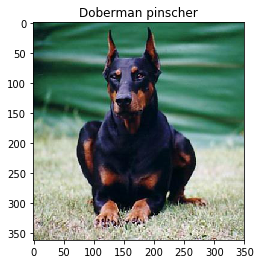

In [10]:
import matplotlib.pyplot as plt

def display_image(img_path, title="Title"):
    title = predict_breed_transfer(img_path)[1]
    
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()
    
display_image(dog_files[99])
plt.show()

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [78]:
import cv2    
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob
%matplotlib inline      


# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

                         

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# FACE detector (TRUE/FALSE)

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)

    return len(faces) > 0


# DOG detector (TRUE/FALSE)

import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)


# move model to GPU if CUDA is available
if torch.cuda.is_available():
    VGG16 = VGG16.cuda()
    
def VGG16_predict(img_path):
  
    img = cv2.imread(img_path)
    img_PIL = Image.fromarray(img)

    img_to_tensor = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),
                                        transforms.Normalize(
                                             (0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))
                                       ])

    image = img_to_tensor(img_PIL).unsqueeze(0)
    
    if torch.cuda.is_available():
        image = image.cuda()
    # get sample outputs
    output = VGG16(image)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    #preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    preds =  np.squeeze(preds_tensor.cpu().numpy())
    
    sm = torch.nn.Softmax()
    probabilities = sm(output)
    t_prob, t_label = torch.topk(probabilities,1)

    print(torch.log(t_prob))
    return preds # predicted class index



def dog_detector(img_path):   
    p = VGG16_predict(img_path)
    if p >= 151 and p <= 268:
        return True
    else:
        return False



In [79]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    # check for human faces for head-count
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    # algorithm part 
    a = predict_breed_transfer(img_path)[1]
    b = face_detector(img_path)
    c = dog_detector(img_path)
        
    if c==True or b==True:
        tagline_1 = "Number of humans: " + str(len(faces))
        tagline_2 = "Dog breed label: " + a
        tag = tagline_1 + '\n' + tagline_2
    if c==False and b==False:
        tag = "No dogs or humans on image!"
       
    
    
    # plot the image 

    
    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    #plt.show()
    
    #image = Image.open(img_path)
    plt.title( tag )
    #plt.imshow(image)
    plt.show()
        



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-1.7434]], device='cuda:0')


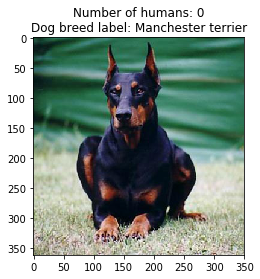

In [80]:
run_app(dog_files[99])


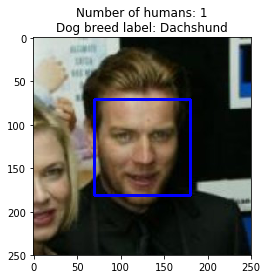

In [55]:
run_app(human_files[99])


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The observable detection of humans is acceptable, and it works decently. It even detects multiple faces on the image. However, in cases when the human is not frontally oriented, it fails to detect a face. 

I downloaded also random images from the internet to test how the algorithm performs on images containing flowers, airplanes. Here the human and dog detection failed miserably. On the image of a tulip (below) it detected even two faces and a dog. Moreover, the bounding boxer for the faces are way too small. It would be great to implement some kind of fall-back case, for situations like this, to handle classification with low probability values. 

I tested the algorithm on images that contain both a dog and a human. In such cases it is difficult to understand to which object (face or dog) is ti corresponding dog breed name referring to. This problem becomes more clear when multiple faces and multiple dogs are on one image. 

In order to improve the intention and the functionality of the app image segmentation would be good to have. In cases such as images with multiple dogs and humans, the algorithm should identify the number of dogs on the image, and for each separately determine the predicted breed name. 

A second point of improvement could be the improvement of the accuracy of the model.
Thirdly, a confidence value (or prediction probability percentage) could be added in the text for better experience. 

Additionally, it would be great to have the app that can do the image classification directly from the webcam video input. This could be easily done in opencv, by capturing the frames from the webcam and in a while loop evaluate the image and derive the predicted class.

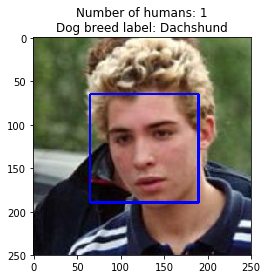

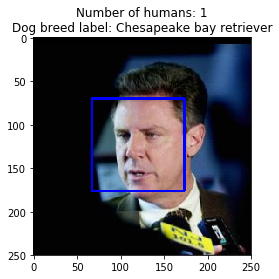

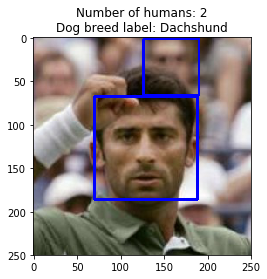

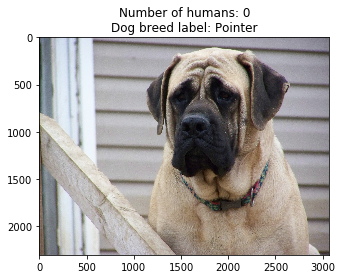

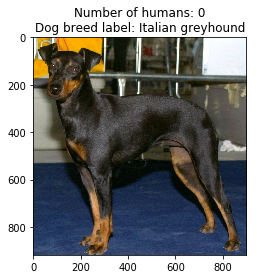

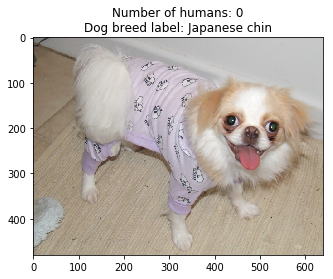

In [69]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below

for file in np.hstack((human_files[2:302:100], dog_files[3:3003:1000])):
    run_app(file)

In [5]:


### Testing on random photos from internet (links from simple google image search)




In [24]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/close-up-of-water-drops-on-pink-flower-royalty-free-image-1129286570-1550867689.jpg

--2019-04-22 18:31:20--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/close-up-of-water-drops-on-pink-flower-royalty-free-image-1129286570-1550867689.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1051513 (1.0M) [image/jpeg]
Saving to: ‘close-up-of-water-drops-on-pink-flower-royalty-free-image-1129286570-1550867689.jpg’

close-up-of-water-d 100%[===================>]   1.00M  --.-KB/s    in 0.06s   

2019-04-22 18:31:21 (16.6 MB/s) - ‘close-up-of-water-drops-on-pink-flower-royalty-free-image-1129286570-1550867689.jpg’ saved [1051513/1051513]



In [36]:
!wget https://i2-prod.mirror.co.uk/incoming/article11173347.ece/ALTERNATES/s615/PROD-Airplane-flying-above-clouds.jpg

--2019-04-22 19:11:51--  https://i2-prod.mirror.co.uk/incoming/article11173347.ece/ALTERNATES/s615/PROD-Airplane-flying-above-clouds.jpg
Resolving i2-prod.mirror.co.uk (i2-prod.mirror.co.uk)... 184.26.100.143
Connecting to i2-prod.mirror.co.uk (i2-prod.mirror.co.uk)|184.26.100.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20128 (20K) [image/jpeg]
Saving to: ‘PROD-Airplane-flying-above-clouds.jpg’

PROD-Airplane-flyin 100%[===================>]  19.66K  --.-KB/s    in 0s      

2019-04-22 19:11:51 (232 MB/s) - ‘PROD-Airplane-flying-above-clouds.jpg’ saved [20128/20128]



In [38]:
!wget https://image1.masterfile.com/getImage/NzAwLTA1ODIyMDU0ZW4uMDAwMDAwMDA=AJwWW3/700-05822054en_Masterfile.jpg

--2019-04-22 19:14:43--  https://image1.masterfile.com/getImage/NzAwLTA1ODIyMDU0ZW4uMDAwMDAwMDA=AJwWW3/700-05822054en_Masterfile.jpg
Resolving image1.masterfile.com (image1.masterfile.com)... 45.60.12.7
Connecting to image1.masterfile.com (image1.masterfile.com)|45.60.12.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19880 (19K) [image/jpeg]
Saving to: ‘700-05822054en_Masterfile.jpg’

700-05822054en_Mast 100%[===================>]  19.41K  --.-KB/s    in 0.03s   

2019-04-22 19:14:43 (664 KB/s) - ‘700-05822054en_Masterfile.jpg’ saved [19880/19880]



In [35]:
!wget https://cdn0.wideopenpets.com/wp-content/uploads/2017/11/Untitled-design-67-770x405.jpg

--2019-04-22 23:12:44--  https://cdn0.wideopenpets.com/wp-content/uploads/2017/11/Untitled-design-67-770x405.jpg
Resolving cdn0.wideopenpets.com (cdn0.wideopenpets.com)... 104.25.232.5, 104.25.233.5, 2606:4700:20::6819:e905, ...
Connecting to cdn0.wideopenpets.com (cdn0.wideopenpets.com)|104.25.232.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42768 (42K) [image/jpeg]
Saving to: ‘Untitled-design-67-770x405.jpg’

Untitled-design-67- 100%[===================>]  41.77K  --.-KB/s    in 0.007s  

2019-04-22 23:12:44 (5.83 MB/s) - ‘Untitled-design-67-770x405.jpg’ saved [42768/42768]



In [39]:
!wget https://petapixel.com/assets/uploads/2018/09/dogshumansfeattt.jpg

--2019-04-22 23:14:09--  https://petapixel.com/assets/uploads/2018/09/dogshumansfeattt.jpg
Resolving petapixel.com (petapixel.com)... 104.25.177.117, 104.25.178.117, 2606:4700:20::6819:b275, ...
Connecting to petapixel.com (petapixel.com)|104.25.177.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158450 (155K) [image/jpeg]
Saving to: ‘dogshumansfeattt.jpg’

dogshumansfeattt.jp 100%[===================>] 154.74K  --.-KB/s    in 0.03s   

2019-04-22 23:14:09 (5.53 MB/s) - ‘dogshumansfeattt.jpg’ saved [158450/158450]



In [44]:
!wget https://theawesomedaily.com/wp-content/uploads/2016/08/humans-look-like-dogs-5-1.jpg

--2019-04-22 23:16:08--  https://theawesomedaily.com/wp-content/uploads/2016/08/humans-look-like-dogs-5-1.jpg
Resolving theawesomedaily.com (theawesomedaily.com)... 75.98.172.240
Connecting to theawesomedaily.com (theawesomedaily.com)|75.98.172.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56146 (55K) [image/jpeg]
Saving to: ‘humans-look-like-dogs-5-1.jpg’

humans-look-like-do 100%[===================>]  54.83K  --.-KB/s    in 0.05s   

2019-04-22 23:16:09 (1.06 MB/s) - ‘humans-look-like-dogs-5-1.jpg’ saved [56146/56146]



In [47]:
!wget http://justsomething.co/wp-content/uploads/2018/09/20-funny-photos-of-dogs-looking-just-like-celebrities-758x397.jpg

--2019-04-22 23:17:45--  http://justsomething.co/wp-content/uploads/2018/09/20-funny-photos-of-dogs-looking-just-like-celebrities-758x397.jpg
Resolving justsomething.co (justsomething.co)... 66.55.146.115
Connecting to justsomething.co (justsomething.co)|66.55.146.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48281 (47K) [image/jpeg]
Saving to: ‘20-funny-photos-of-dogs-looking-just-like-celebrities-758x397.jpg’

20-funny-photos-of- 100%[===================>]  47.15K  --.-KB/s    in 0.05s   

2019-04-22 23:17:45 (873 KB/s) - ‘20-funny-photos-of-dogs-looking-just-like-celebrities-758x397.jpg’ saved [48281/48281]



In [49]:
!wget http://newsneednews.com/wp-content/uploads/2018/09/ccelebritiesfoto4FAA319100000578-0-image-a-132_1535983826394.jpg

--2019-04-22 23:19:29--  http://newsneednews.com/wp-content/uploads/2018/09/ccelebritiesfoto4FAA319100000578-0-image-a-132_1535983826394.jpg
Resolving newsneednews.com (newsneednews.com)... 104.27.187.31, 104.27.186.31, 2606:4700:30::681b:bb1f, ...
Connecting to newsneednews.com (newsneednews.com)|104.27.187.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64888 (63K) [image/jpeg]
Saving to: ‘ccelebritiesfoto4FAA319100000578-0-image-a-132_1535983826394.jpg’

ccelebritiesfoto4FA 100%[===================>]  63.37K  --.-KB/s    in 0.02s   

2019-04-22 23:19:30 (3.59 MB/s) - ‘ccelebritiesfoto4FAA319100000578-0-image-a-132_1535983826394.jpg’ saved [64888/64888]



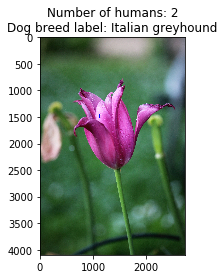

In [57]:
# Two faces and a dog were found in this image of a flower....hmmmm... 

run_app("./close-up-of-water-drops-on-pink-flower-royalty-free-image-1129286570-1550867689.jpg")

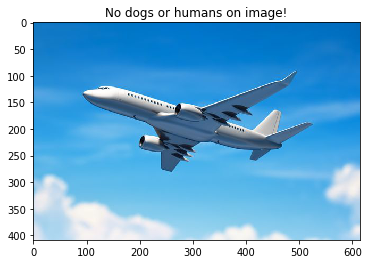

In [58]:
run_app("./PROD-Airplane-flying-above-clouds.jpg")

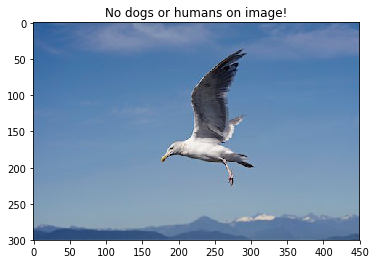

In [59]:
run_app("./700-05822054en_Masterfile.jpg")

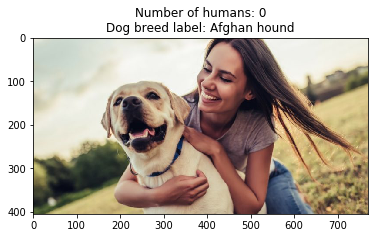

In [60]:
run_app("./Untitled-design-67-770x405.jpg")

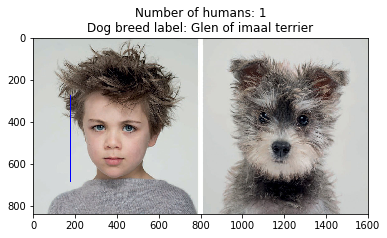

In [61]:
run_app("./dogshumansfeattt.jpg")

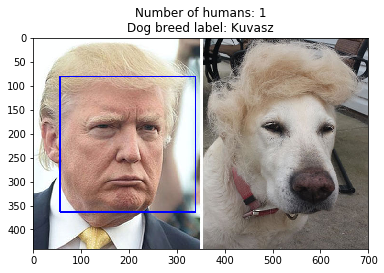

In [62]:
run_app("./humans-look-like-dogs-5-1.jpg")

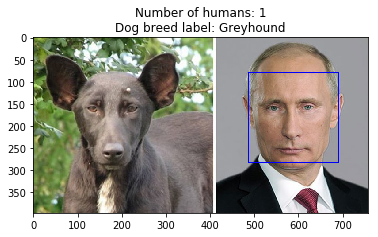

In [63]:
run_app("./20-funny-photos-of-dogs-looking-just-like-celebrities-758x397.jpg")

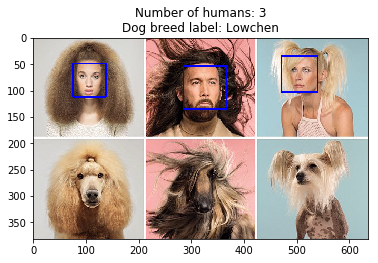

In [64]:
run_app("./ccelebritiesfoto4FAA319100000578-0-image-a-132_1535983826394.jpg")

In [65]:
"""
How to segment multiple dogs on an image and determine the breed for each ? 

"""

'\nHow to segment multiple dogs on an image and determine the breed for each ? \n\n'

### I have two appendixes:

-Appendix 1  human gender classifier 

-Appendix 2 GradCam


# Appendix 1

In [1]:
# Male female classifier
"""
Idea:
I thought to write a NN that can make difference between male and female human faces.
For this I planned to use the human_files, since they contain the names of the celebrity in the image. 
From the name the gender can be inferred and used as the label for the images. 
The preprocessing of the data would take the input photo, cut out a rectangle with the face,
and store this image together with the gender name obtained from the filename.

The gender determination from the name (filename) was done using "gender-guesser" package. 

I did not have enough time to finalize this idea.

Question that I found:
- how can I load filepath names from a list into the train, test loader? This would be good in order not to copy
and move image files to a new location for the train and test folder. There was not enough drive space to make 
a train folder with the male and female images. 

"""
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [14]:
!pip install Genderize

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install gender-guesser

    100% |████████████████████████████████| 389kB 1.2MB/s eta 0:00:01
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
human_files[0]

'/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'

In [17]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          49G   39G  9.7G  81% /
tmpfs            64M     0   64M   0% /dev
tmpfs           1.9G     0  1.9G   0% /sys/fs/cgroup
/dev/sdb         20G   14G  5.6G  72% /data
/dev/loop0      3.0G  2.7G  119M  96% /home/workspace
/dev/sda1        49G   39G  9.7G  81% /home/backups
shm              64M     0   64M   0% /dev/shm
tmpfs           1.9G     0  1.9G   0% /proc/acpi
tmpfs           1.9G     0  1.9G   0% /proc/scsi
tmpfs           1.9G     0  1.9G   0% /sys/firmware


In [20]:
# take 1/4 of the 13233 total human files due to hard drive space 
quarter_human_files = human_files[::4]

In [21]:
len(quarter_human_files)

3309

In [75]:
# dict of filenames and determined gender from the first name
import gender_guesser.detector as gender
from shutil import copyfile

males, females = [], []
for i in human_files[100:200]:
    first_name = i.split('/')[-1].split('_')[0] 
    
    # Genderize has limit of 429 request 
    #gender = Genderize().get([first_name]) 
    # switching to gender_guesser
    gender_guess = gender.Detector().get_gender( first_name )
    
    #print(i, gender[0].get('gender'),gender[0].get('probability'))
    
    # generate list of image paths for female and male images 
    #if gender[0].get('gender') == 'male':
    if gender_guess == 'male':
        males.append(i)
        copyfile(i,'/home/workspace/dog_project/gender_test/train/male/'+i.split('/')[-1])
    #elif gender[0].get('gender') == 'female':
    elif gender_guess == 'female':
        females.append(i)
        copyfile(i,'/home/workspace/dog_project/gender_test/train/female/'+i.split('/')[-1])

        

In [77]:
ls -ltr ./gender_test/train/female/ | wc

     60     533    3958


In [68]:
!du -sh /data/lfw/

229M	/data/lfw/


In [78]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          49G   40G  8.7G  83% /
tmpfs            64M     0   64M   0% /dev
tmpfs           1.9G     0  1.9G   0% /sys/fs/cgroup
/dev/sdb         20G   14G  5.6G  72% /data
/dev/loop0      3.0G  2.7G  116M  96% /home/workspace
/dev/sda1        49G   40G  8.7G  83% /home/backups
shm              64M     0   64M   0% /dev/shm
tmpfs           1.9G     0  1.9G   0% /proc/acpi
tmpfs           1.9G     0  1.9G   0% /proc/scsi
tmpfs           1.9G     0  1.9G   0% /sys/firmware


In [52]:
len(males)

56

In [53]:
len(females)

29

In [54]:
len(human_files)

13233

In [59]:
!mkdir ./gender_test/train/female


# Appendix 2

In [1]:
!pip install Pillow==5.4.1
from PIL import Image
import PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
PIL.__version__

    100% |████████████████████████████████| 2.0MB 276kB/s eta 0:00:01
  Found existing installation: Pillow 6.0.0
    Uninstalling Pillow-6.0.0:
      Successfully uninstalled Pillow-6.0.0
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


'5.4.1'

In [2]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

#AJ modified to W,H,D instead of D,W,H
def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=2)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    #grayscale_im = np.expand_dims(grayscale_im, axis=2)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


def preprocess_image(pil_im, resize_im=True, device="cuda"):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    # mean = [0.485, 0.456, 0.406]
    # std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((512, 512))
    #im_as_arr = np.float32(pil_im)
    #im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    # for channel, _ in enumerate(im_as_arr):
        # im_as_arr[channel] /= 255
        # im_as_arr[channel] -= mean[channel]
        # im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = transforms.functional.to_tensor(pil_im)
    #im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten.to(device), requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    # reverse_mean = [-0.485, -0.456, -0.406]
    # reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.cpu().data.numpy()[0])
    # for c in range(3):
        # recreated_im[c] /= reverse_std[c]
        # recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = ( ('/home/workspace/dog_project/dd_tree.jpg', 243),
                    ('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg', 256),
                   ('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00002.jpg', 256))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    print(file_name_to_export, img_path)
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
pretrained_model)

In [5]:
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F


#from misc_functions import get_example_params, save_class_activation_images


class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in enumerate(self.model.features._modules.items()):
            x = module[1](x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        #x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, device, target_layer):
        self.device = device
        self.model = model.to(device)
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().to(self.device)
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        # Get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = cv2.resize(cam, (224, 224))
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        return cam

    
# Get params
target_example = 1
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(target_example)
# Grad cam
grad_cam = GradCam(pretrained_model, 'cuda', target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')

Affenpinscher_00001 /data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg


RuntimeError: size mismatch, m1: [1 x 256], m2: [9216 x 4096] at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THC/generic/THCTensorMathBlas.cu:249

In [ ]:
#*

In [5]:
pwd

'/home/workspace/dog_project'